## Управление потоком жидкости

<img src="assets/fis.png" width="600" style="background-color: white">

#### Создание лингвистических переменных

Входные X: level (уровень жидкости) и flow (расход жидкости) \
Выходные Y: influx (приток жидкости)

In [1]:
import numpy as np
from skfuzzy import control as ctrl

level = ctrl.Antecedent(np.arange(1.5, 9.0, 0.1), "level")
flow = ctrl.Antecedent(np.arange(0, 0.6, 0.01), "flow")
influx = ctrl.Consequent(np.arange(0, 0.6, 0.01), "influx")

#### Формирование нечетких переменных для лингвистических переменных и их визуализация

/Users/user/Projects/python/mai/.venv/lib/python3.12/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


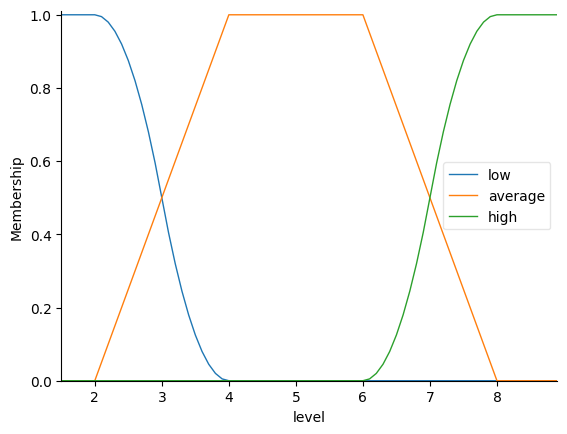

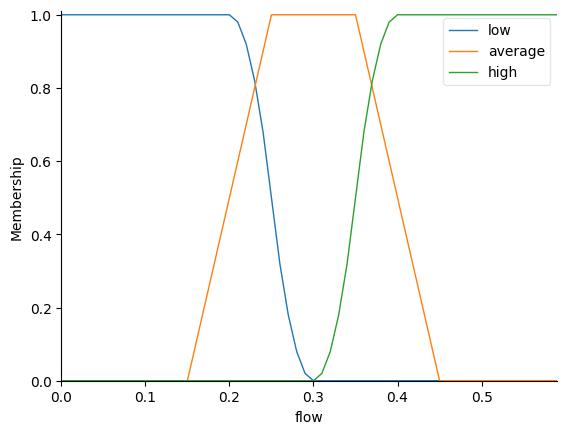

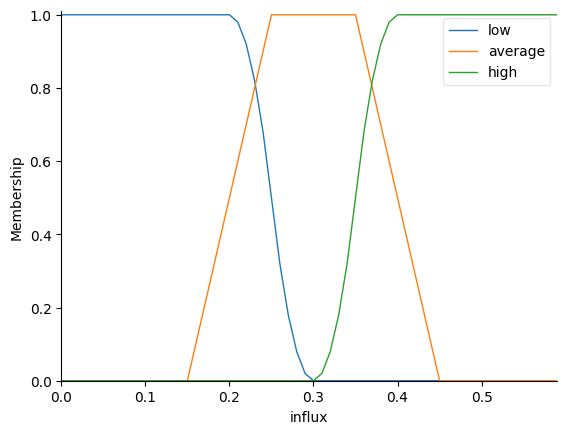

In [2]:
import skfuzzy as fuzz

level["low"] = fuzz.zmf(level.universe, 2, 4)
level["average"] = fuzz.trapmf(level.universe, [2, 4, 6, 8])
level["high"] = fuzz.smf(level.universe, 6, 8)
level.view()

flow["low"] = fuzz.zmf(flow.universe, 0.2, 0.3)
flow["average"] = fuzz.trapmf(flow.universe, [0.15, 0.25, 0.35, 0.45])
flow["high"] = fuzz.smf(flow.universe, 0.3, 0.4)
flow.view()

influx["low"] = fuzz.zmf(influx.universe, 0.2, 0.3)
influx["average"] = fuzz.trapmf(influx.universe, [0.15, 0.25, 0.35, 0.45])
influx["high"] = fuzz.smf(influx.universe, 0.3, 0.4)
influx.view()

#### Формирование и визуализация базы нечетких правил

В случае ошибки необходимо в файле
```
.venv/lib/python3.13/site-packages/skfuzzy/control/visualization.py
```
удалить лишний отступ на 182 строке, должно быть:
```python
        if not matplotlib_present:
            raise ImportError("`ControlSystemVisualizer` can only be used "
                              "with `matplotlib` present in the system.")

        self.ctrl = control_system

        self.fig, self.ax = plt.subplots()
```

(<Figure size 640x480 with 1 Axes>, <Axes: >)

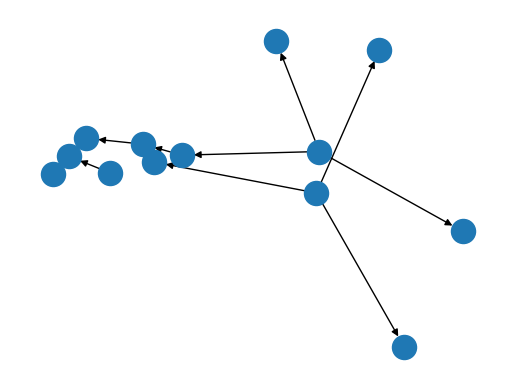

In [3]:
rule1 = ctrl.Rule(level["low"] & flow["high"], influx["high"])
rule2 = ctrl.Rule(level["low"] & flow["average"], influx["high"])
rule3 = ctrl.Rule(level["low"] & flow["low"], influx["average"])
rule4 = ctrl.Rule(level["average"] & flow["high"], influx["high"])
rule5 = ctrl.Rule(level["average"] & flow["average"], influx["average"])
rule6 = ctrl.Rule(level["average"] & flow["low"], influx["average"])
rule7 = ctrl.Rule(level["high"] & flow["high"], influx["average"])
rule8 = ctrl.Rule(level["high"] & flow["average"], influx["low"])
rule9 = ctrl.Rule(level["high"] & flow["low"], influx["low"])

rule1.view()

#### Создание нечеткой системы и добавление нечетких правил в базу знаний нечеткой системы

In [4]:
influx_ctrl = ctrl.ControlSystem(
    [
        rule1,
        rule2,
        rule3,
        rule4,
        rule5,
        rule6,
        rule7,
        rule8,
        rule9,
    ]
)

influxes = ctrl.ControlSystemSimulation(influx_ctrl)

#### Пример расчета выходной переменной influx на основе входных переменных level и flow

Система также формирует подробный журнал выполнения процесса нечеткого логического вывода

In [5]:
influxes.input["level"] = 2.5
influxes.input["flow"] = 0.4
influxes.compute()
influxes.print_state()
influxes.output["influx"]

 Antecedents 
Antecedent: level                   = 2.5
  - low                             : 0.875
  - average                         : 0.25
  - high                            : 0.0
Antecedent: flow                    = 0.4
  - low                             : 0.0
  - average                         : 0.4999999999999997
  - high                            : 1.0

 Rules 
RULE #0:
  IF level[low] AND flow[high] THEN influx[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - level[low]                                             : 0.875
  - flow[high]                                             : 1.0
                                 level[low] AND flow[high] = 0.875
  Activation (THEN-clause):
                                              influx[high] : 0.875

RULE #1:
  IF level[low] AND flow[average] THEN influx[high]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - level[low]       

0.4315251220586045

#### Визуализация функции принадлежности для выходной переменной influx

Функция получена в процессе аккумуляции и используется для дефаззификации значения выходной переменной influx

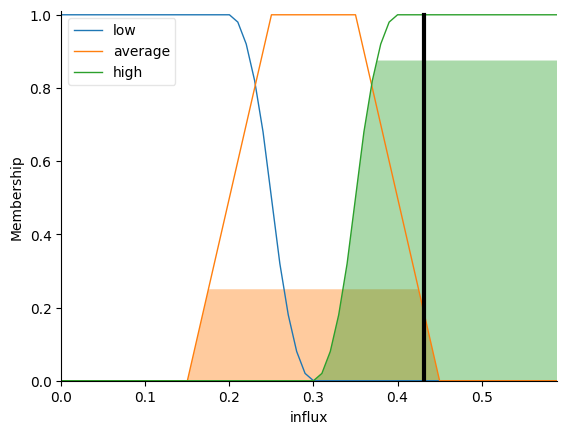

In [6]:
influx.view(sim=influxes)

## Пример решения задачи регрессии на основе нечеткого логического вывода

#### Загрузка данных

In [7]:
import pandas as pd


density_train = pd.read_csv("data/density/density_train.csv", sep=";", decimal=",")
density_test = pd.read_csv("data/density/density_test.csv", sep=";", decimal=",")

display(density_train.head(3))
display(density_test.head(3))

,T,Al2O3,TiO2,Density
0,20,0.0,0.0,1.06250
1,25,0.0,0.0,1.05979
2,35,0.0,0.0,1.05404


,T,Al2O3,TiO2,Density
0,30,0.00,0.0,1.05696
1,55,0.00,0.0,1.04158
2,25,0.05,0.0,1.08438


#### Инициализация лингвистических переменных и автоматическое формирование нечетких переменных

/Users/user/Projects/python/mai/.venv/lib/python3.12/site-packages/skfuzzy/control/fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


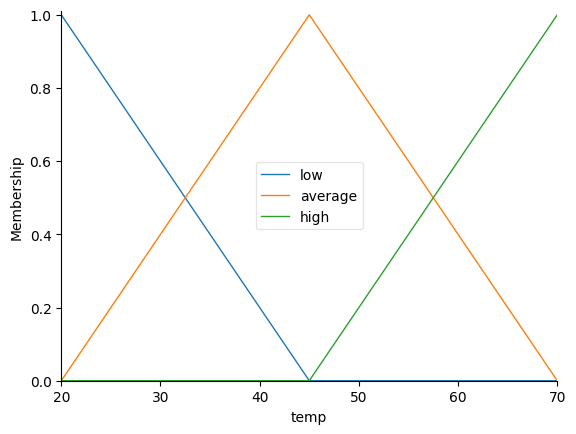

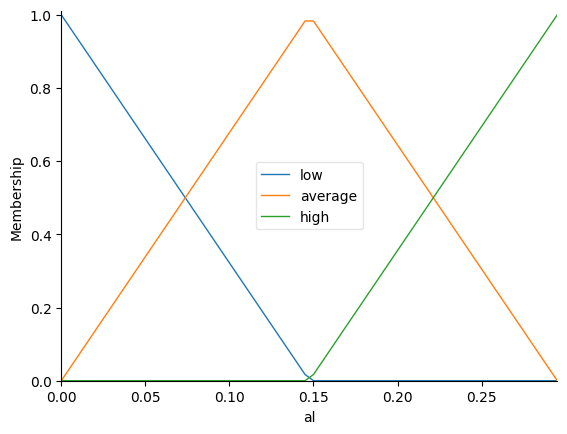

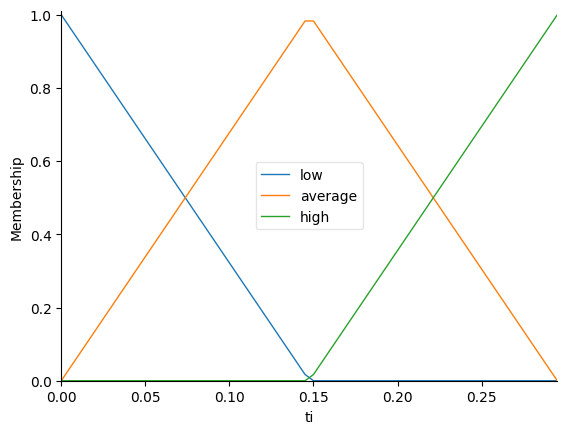

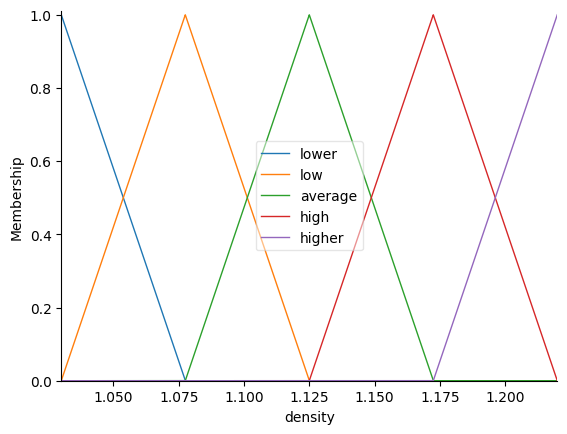

In [8]:
temp = ctrl.Antecedent(density_train["T"].sort_values().unique(), "temp")
al = ctrl.Antecedent(np.arange(0, 0.3, 0.005), "al")
ti = ctrl.Antecedent(np.arange(0, 0.3, 0.005), "ti")
density = ctrl.Consequent(np.arange(1.03, 1.22, 0.00001), "density")

temp.automf(3, variable_type="quant")
temp.view()
al.automf(3, variable_type="quant")
al.view()
ti.automf(3, variable_type="quant")
ti.view()
density.automf(5, variable_type="quant")
density.view()

#### Нечеткие правила

In [9]:
rule11 = ctrl.Rule(
    temp["low"] & al["low"] & ti["low"],
    density["low"],
)
rule12 = ctrl.Rule(
    temp["average"] & al["low"] & ti["low"],
    density["lower"],
)
rule13 = ctrl.Rule(
    temp["high"] & al["low"] & ti["low"],
    density["lower"],
)

rule21 = ctrl.Rule(
    temp["low"] & al["average"] & ti["low"],
    density["low"],
)
rule22 = ctrl.Rule(
    temp["average"] & al["average"] & ti["low"],
    density["low"],
)
rule23 = ctrl.Rule(
    temp["high"] & al["average"] & ti["low"],
    density["lower"],
)

rule31 = ctrl.Rule(
    temp["low"] & al["high"] & ti["low"],
    density["high"],
)
rule32 = ctrl.Rule(
    temp["low"] & al["high"] & ti["low"],
    density["high"],
)
rule33 = ctrl.Rule(
    temp["high"] & al["high"] & ti["low"],
    density["average"],
)

rule41 = ctrl.Rule(
    temp["low"] & al["low"] & ti["average"],
    density["low"],
)
rule42 = ctrl.Rule(
    temp["average"] & al["low"] & ti["average"],
    density["low"],
)
rule43 = ctrl.Rule(
    temp["high"] & al["low"] & ti["average"],
    density["lower"],
)

rule51 = ctrl.Rule(
    temp["low"] & al["low"] & ti["high"],
    density["higher"],
)
rule52 = ctrl.Rule(
    temp["average"] & al["low"] & ti["high"],
    density["high"],
)
rule53 = ctrl.Rule(
    temp["high"] & al["low"] & ti["high"],
    density["high"],
)

#### Создание нечеткой системы

In [10]:
fuzzy_rules = [
    rule11,
    rule12,
    rule13,
    rule21,
    rule22,
    rule23,
    rule31,
    rule32,
    rule33,
    rule41,
    rule42,
    rule43,
    rule51,
    rule52,
    rule53,
]

density_cntrl = ctrl.ControlSystem(fuzzy_rules)

sim = ctrl.ControlSystemSimulation(density_cntrl)

fuzzy_rules

[IF (temp[low] AND al[low]) AND ti[low] THEN density[low]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (temp[average] AND al[low]) AND ti[low] THEN density[lower]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (temp[high] AND al[low]) AND ti[low] THEN density[lower]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (temp[low] AND al[average]) AND ti[low] THEN density[low]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (temp[average] AND al[average]) AND ti[low] THEN density[low]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (temp[high] AND al[average]) AND ti[low] THEN density[lower]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (temp[low] AND al[high]) AND ti[low] THEN density[high]
 	AND aggregation function : fmin
 	OR aggregation function  : fmax,
 IF (temp[low] AND al[high]) AND ti[low] THEN density[high]
 	AND aggregation fun

#### Пример использования полученной нечеткой системы

In [11]:
sim.input["temp"] = 20
sim.input["al"] = 0.3
sim.input["ti"] = 0.0
sim.compute()
sim.print_state()
display(sim.output["density"])

 Antecedents 
Antecedent: temp                    = 20
  - low                             : 1.0
  - average                         : 0.0
  - high                            : 0.0
Antecedent: al                      = 0.295
  - low                             : 0.0
  - average                         : 0.0
  - high                            : 1.0
Antecedent: ti                      = 0.0
  - low                             : 1.0
  - average                         : 0.0
  - high                            : 0.0

 Rules 
RULE #0:
  IF (temp[low] AND al[low]) AND ti[low] THEN density[low]
	AND aggregation function : fmin
	OR aggregation function  : fmax

  Aggregation (IF-clause):
  - temp[low]                                              : 1.0
  - al[low]                                                : 0.0
  - ti[low]                                                : 1.0
                       (temp[low] AND al[low]) AND ti[low] = 0.0
  Activation (THEN-clause):
                      

1.1724924997377486

#### Функция для автоматизации вычисления целевой переменной Y на основе вектора признаков X

In [12]:
def fuzzy_pred(row):
    sim.input["temp"] = row["T"]
    sim.input["al"] = row["Al2O3"]
    sim.input["ti"] = row["TiO2"]
    sim.compute()
    return sim.output["density"]

#### Тестирование нечеткой системы на обучающей выборке

In [14]:
result_train = density_train.copy()

result_train["DensityPred"] = result_train.apply(fuzzy_pred, axis=1)

result_train.head(15)

,T,Al2O3,TiO2,Density,DensityPred
0,20,0.00,0.0,1.06250,1.077498
1,25,0.00,0.0,1.05979,1.076593
2,35,0.00,0.0,1.05404,1.069156
3,40,0.00,0.0,1.05103,1.061106
4,45,0.00,0.0,1.04794,1.045833
5,50,0.00,0.0,1.04477,1.046360
6,60,0.00,0.0,1.03826,1.047642
7,65,0.00,0.0,1.03484,1.046360
8,70,0.00,0.0,1.03182,1.045833
9,20,0.05,0.0,1.08755,1.077498


#### Тестирование нечеткой системы на тестовой выборке

In [15]:
result_test = density_test.copy()

result_test["DensityPred"] = result_test.apply(fuzzy_pred, axis=1)

result_test

,T,Al2O3,TiO2,Density,DensityPred
0,30,0.00,0.00,1.05696,1.073918
1,55,0.00,0.00,1.04158,1.047642
2,25,0.05,0.00,1.08438,1.076518
3,30,0.05,0.00,1.08112,1.073918
4,35,0.05,0.00,1.07781,1.069156
5,40,0.05,0.00,1.07446,1.067145
6,60,0.05,0.00,1.06053,1.067988
7,35,0.30,0.00,1.17459,1.172492
8,65,0.30,0.00,1.14812,1.124995
9,45,0.00,0.05,1.07424,1.067145


#### Оценка результатов на основе метрик для задачи регрессии

In [16]:
import math
from sklearn import metrics


rmetrics = {}
rmetrics["RMSE_train"] = math.sqrt(
    metrics.mean_squared_error(result_train["Density"], result_train["DensityPred"])
)
rmetrics["RMSE_test"] = math.sqrt(
    metrics.mean_squared_error(result_test["Density"], result_test["DensityPred"])
)
rmetrics["RMAE_test"] = math.sqrt(
    metrics.mean_absolute_error(result_test["Density"], result_test["DensityPred"])
)
rmetrics["R2_test"] = metrics.r2_score(
    result_test["Density"], result_test["DensityPred"]
)

rmetrics

{'RMSE_train': 0.0156766544822719,
 'RMSE_test': 0.014603864614526584,
 'RMAE_test': 0.1057231829134674,
 'R2_test': 0.9436578668511394}